In [12]:
# Step 1: setup + load sports and crypto data

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pathlib import Path

# Display options
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 120)

BASE_DIR = Path("..")
DATA_PATH = BASE_DIR / "data" / "enriched_markets.csv"

# Load data
enriched_markets_df = pd.read_csv(DATA_PATH)
print("Loaded:", enriched_markets_df.shape)

# Keep only Sports and Crypto
categories_to_keep = ["Sports", "Crypto"]
filtered_df = enriched_markets_df[enriched_markets_df["category"].isin(categories_to_keep)].copy()
print("Filtered to:", filtered_df.shape)

filtered_df["category"].value_counts()


Loaded: (800, 14)
Filtered to: (800, 14)


category
Sports    400
Crypto    400
Name: count, dtype: int64

In [14]:
# Step 2: compute enhanced features

TRADES_DIR = BASE_DIR / "kalshi_fetcher" / "data" / "enriched_trades"

def compute_stronger_features(market_row):
    ticker = market_row["ticker"]
    path = TRADES_DIR / f"{ticker}.csv"
    if not path.exists():
        return None
    
    df = pd.read_csv(path)
    if df.empty:
        return None

    # ensure timestamps
    df["created_time_dt"] = pd.to_datetime(df["created_time_dt"])
    event_time = pd.to_datetime(market_row["event_time"])

    # focus only on trades before the event
    df = df[df["seconds_before_event"] >= 0]
    if df.empty:
        return None

    # base stats
    vol_total = df["count"].sum()
    if vol_total == 0:
        return None

    # 30m and 1h windows
    win_30m = df[df["seconds_before_event"] <= 1800]
    win_1h  = df[df["seconds_before_event"] <= 3600]

    # --- features ---
    vol_30m = win_30m["count"].sum()
    late_volume_ratio = vol_30m / vol_total

    if not win_30m.empty and len(df) > len(win_30m):
        price_before = df.iloc[-len(win_30m) - 1]["price"]
        price_last = win_30m.iloc[-1]["price"]
        abs_price_jump = abs(price_last - price_before)
    else:
        abs_price_jump = 0

    yes = win_1h.loc[win_1h["taker_side"] == "yes", "count"].sum()
    no  = win_1h.loc[win_1h["taker_side"] == "no", "count"].sum()
    yes_flow_ratio = (yes - no) / (yes + no) if (yes + no) > 0 else 0

    price_std_1h = win_1h["price"].std(ddof=0) if len(win_1h) > 1 else 0

    return {
        "ticker": ticker,
        "category": market_row["category"],
        "event_ticker": market_row["event_ticker"],
        "late_volume_ratio": late_volume_ratio,
        "abs_price_jump": abs_price_jump,
        "yes_flow_ratio": yes_flow_ratio,
        "price_std_1h": price_std_1h,
        "vol_total": vol_total,
    }

test_row = filtered_df.iloc[0]
feat = compute_stronger_features(test_row)
pd.Series(feat)


Series([], dtype: object)

In [ ]:
# List all tickers we actually have enriched trades for
available_tickers = sorted([p.stem for p in TRADES_DIR.glob("*.csv")])

print("Number of tickers with trades files:", len(available_tickers))
print("Sample:", available_tickers[:10])


Number of tickers with trades files: 596
Sample: ['KXALEAGUEGAME-25NOV08SYDMAC-SYD', 'KXALEAGUEGAME-25NOV08VICMEL-MEL', 'KXALEAGUEGAME-25NOV08WPHAUC-AUC', 'KXALEAGUEGAME-25NOV08WPHAUC-TIE', 'KXALEAGUEGAME-25NOV08WPHAUC-WPH', 'KXALEAGUEGAME-25NOV09BRRNUJ-BRR', 'KXALEAGUEGAME-25NOV09BRRNUJ-NUJ', 'KXATPMATCH-25NOV08DJOMUS-DJO', 'KXATPMATCH-25NOV08DJOMUS-MUS', 'KXATPMATCH-25NOV08NORTIE-NOR']


In [18]:
usable_df = filtered_df[filtered_df["ticker"].isin(available_tickers)].copy()
print("Markets with both metadata + trades:", usable_df.shape)
print(usable_df["category"].value_counts())


Markets with both metadata + trades: (596, 14)
category
Sports    396
Crypto    200
Name: count, dtype: int64


In [19]:
# Test compute_stronger_features on a market we know has trades
test_row = usable_df.iloc[0]
print("Test ticker with trades:", test_row["ticker"])

feat_test = compute_stronger_features(test_row)
print("\nFeatures returned:")
print(feat_test)


Test ticker with trades: KXNCAAMBTOTAL-25NOV08BELLKSU-184

Features returned:
{'ticker': 'KXNCAAMBTOTAL-25NOV08BELLKSU-184', 'category': 'Sports', 'event_ticker': 'KXNCAAMBTOTAL-25NOV08BELLKSU', 'late_volume_ratio': np.float64(1.0), 'abs_price_jump': 0, 'yes_flow_ratio': np.float64(-1.0), 'price_std_1h': 0.0, 'vol_total': np.int64(199)}


In [20]:
# Step 5: compute stronger features for all markets with trades

features_v2 = []

total = len(usable_df)
print(f"Computing stronger features for {total} markets...")

for i, (_, row) in enumerate(usable_df.iterrows(), start=1):
    feat = compute_stronger_features(row)
    if feat is not None:
        features_v2.append(feat)

    if i % 25 == 0 or i == total:
        print(f"Processed {i}/{total}", end="\r")

print("\nDone.")

features_v2_df = pd.DataFrame(features_v2)
print("features_v2_df shape:", features_v2_df.shape)
display(features_v2_df.head())


Computing stronger features for 596 markets...


C:\Users\Adam Nhan\AppData\Local\Temp\ipykernel_21188\2206970961.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["created_time_dt"] = pd.to_datetime(df["created_time_dt"])


Processed 596/596
Done.
features_v2_df shape: (596, 8)


,ticker,category,event_ticker,late_volume_ratio,abs_price_jump,yes_flow_ratio,price_std_1h,vol_total
0,KXNCAAMBTOTAL-25NOV08BELLKSU-184,Sports,KXNCAAMBTOTAL-25NOV08BELLKSU,1.0,0.0,-1.0,0.0,199
1,KXNCAAMBTOTAL-25NOV08BELLKSU-181,Sports,KXNCAAMBTOTAL-25NOV08BELLKSU,1.0,0.0,-1.0,0.0,199
2,KXNCAAMBTOTAL-25NOV08UTAUNM-144,Sports,KXNCAAMBTOTAL-25NOV08UTAUNM,0.0,0.0,-1.0,0.0,199
3,KXNCAAMBTOTAL-25NOV08UTAUNM-141,Sports,KXNCAAMBTOTAL-25NOV08UTAUNM,0.0,0.0,-1.0,0.0,199
4,KXNCAAMBTOTAL-25NOV08UTAUNM-135,Sports,KXNCAAMBTOTAL-25NOV08UTAUNM,0.0,0.0,-1.0,0.0,199


In [21]:
# Step 6: compute z-scores per category to remove category bias

def add_category_zscores(df, columns):
    result = df.copy()
    for col in columns:
        result[f"z_{col}"] = (
            result.groupby("category")[col]
            .transform(lambda x: (x - x.mean()) / x.std(ddof=0))
            .fillna(0)
        )
    return result

cols_to_standardize = ["late_volume_ratio", "abs_price_jump", "yes_flow_ratio", "price_std_1h"]
features_v2_df = add_category_zscores(features_v2_df, cols_to_standardize)

display(features_v2_df.head())


,ticker,category,event_ticker,late_volume_ratio,abs_price_jump,yes_flow_ratio,price_std_1h,vol_total,z_late_volume_ratio,z_abs_price_jump,z_yes_flow_ratio,z_price_std_1h
0,KXNCAAMBTOTAL-25NOV08BELLKSU-184,Sports,KXNCAAMBTOTAL-25NOV08BELLKSU,1.0,0.0,-1.0,0.0,199,3.181711,-0.48513,-1.644618,-0.572094
1,KXNCAAMBTOTAL-25NOV08BELLKSU-181,Sports,KXNCAAMBTOTAL-25NOV08BELLKSU,1.0,0.0,-1.0,0.0,199,3.181711,-0.48513,-1.644618,-0.572094
2,KXNCAAMBTOTAL-25NOV08UTAUNM-144,Sports,KXNCAAMBTOTAL-25NOV08UTAUNM,0.0,0.0,-1.0,0.0,199,-0.501770,-0.48513,-1.644618,-0.572094
3,KXNCAAMBTOTAL-25NOV08UTAUNM-141,Sports,KXNCAAMBTOTAL-25NOV08UTAUNM,0.0,0.0,-1.0,0.0,199,-0.501770,-0.48513,-1.644618,-0.572094
4,KXNCAAMBTOTAL-25NOV08UTAUNM-135,Sports,KXNCAAMBTOTAL-25NOV08UTAUNM,0.0,0.0,-1.0,0.0,199,-0.501770,-0.48513,-1.644618,-0.572094


In [22]:
# Step 7: compute stronger suspicion score (v2)

features_v2_df["suspicion_score_v2"] = (
    1.2 * features_v2_df["z_late_volume_ratio"].clip(lower=0)
    + 0.8 * features_v2_df["z_abs_price_jump"].clip(lower=0)
    + 0.6 * features_v2_df["z_yes_flow_ratio"].abs()
    + 0.5 * features_v2_df["z_price_std_1h"].clip(lower=0)
)

ranked_v2 = features_v2_df.sort_values("suspicion_score_v2", ascending=False)

display(
    ranked_v2[
        [
            "ticker",
            "category",
            "suspicion_score_v2",
            "z_late_volume_ratio",
            "z_abs_price_jump",
            "z_yes_flow_ratio",
            "z_price_std_1h",
        ]
    ].head(10)
)


,ticker,category,suspicion_score_v2,z_late_volume_ratio,z_abs_price_jump,z_yes_flow_ratio,z_price_std_1h
301,KXJLEAGUEGAME-25NOV09MACTOK-TOK,Sports,9.093506,3.000387,4.227817,0.547146,3.564999
377,KXKLEAGUEGAME-25NOV08DAGGWA-DAG,Sports,8.963871,2.529200,4.758023,0.663115,3.449087
347,KXKLEAGUEGAME-25NOV08DAGGWA-TIE,Sports,8.342486,3.041048,3.344139,0.327085,3.643331
340,KXNFL2TD-25NOV09ATLIND-ATLTALLGEIER25,Sports,7.624260,2.781583,2.637197,1.219255,2.890099
324,KXJLEAGUEGAME-25NOV09MACTOK-TIE,Sports,6.732595,2.839531,2.224814,0.499560,2.491138
152,KXNCAAMBTOTAL-25NOV08ARKMSU-146,Sports,6.667943,2.701257,3.049580,-1.644618,-0.572094
251,KXJLEAGUEGAME-25NOV09GAMVIK-GAM,Sports,6.580909,1.517172,3.697610,0.503078,3.000735
288,KXNFL2TD-25NOV09ATLIND-INDJTAYLOR28,Sports,5.978406,1.546419,2.813933,1.207663,2.293918
403,KXBTCD-25NOV0909-T102749.99,Crypto,5.865171,1.193999,3.700510,0.101617,2.821989
441,KXBTC-25NOV0822-B101625,Crypto,5.743904,1.424394,3.259485,-0.642023,2.083658


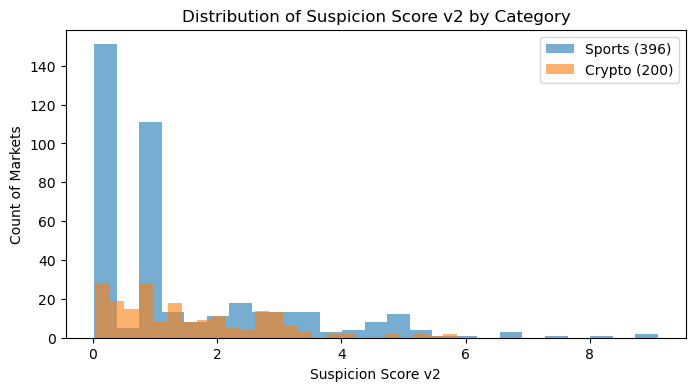

In [23]:
# Step 8: visualize suspicion_score_v2 distribution and category patterns

import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
for cat in features_v2_df["category"].unique():
    subset = features_v2_df[features_v2_df["category"] == cat]
    plt.hist(
        subset["suspicion_score_v2"],
        bins=25,
        alpha=0.6,
        label=f"{cat} ({len(subset)})"
    )

plt.title("Distribution of Suspicion Score v2 by Category")
plt.xlabel("Suspicion Score v2")
plt.ylabel("Count of Markets")
plt.legend()
plt.show()


In [26]:
# Step 9 (fixed): merge suspicion scores with market results

base_df = pd.read_csv(BASE_DIR / "data" / "enriched_markets.csv")

# Check which outcome columns exist
print("Columns in enriched_markets.csv:")
print(base_df.columns.tolist())

# Merge using the actual result column
merged_df = features_v2_df.merge(
    base_df[["ticker", "category", "result"]],
    on=["ticker", "category"],
    how="left"
)

print("Merged shape:", merged_df.shape)
merged_df[["ticker", "category", "suspicion_score_v2", "result"]].head()


Columns in enriched_markets.csv:
['ticker', 'event_ticker', 'category', 'normalized_status', 'status', 'close_time', 'volume', 'last_price', 'result', 'settlement_value', 'title', 'category_event', 'series_ticker', 'event_time']
Merged shape: (596, 14)


,ticker,category,suspicion_score_v2,result
0,KXNCAAMBTOTAL-25NOV08BELLKSU-184,Sports,4.804824,no
1,KXNCAAMBTOTAL-25NOV08BELLKSU-181,Sports,4.804824,no
2,KXNCAAMBTOTAL-25NOV08UTAUNM-144,Sports,0.986771,no
3,KXNCAAMBTOTAL-25NOV08UTAUNM-141,Sports,0.986771,no
4,KXNCAAMBTOTAL-25NOV08UTAUNM-135,Sports,0.986771,no


In [27]:
# Step 10: create numeric target for YES outcomes

merged_df["is_yes"] = (merged_df["result"] == "yes").astype(int)

merged_df[["ticker", "category", "suspicion_score_v2", "result", "is_yes"]].head()


,ticker,category,suspicion_score_v2,result,is_yes
0,KXNCAAMBTOTAL-25NOV08BELLKSU-184,Sports,4.804824,no,0
1,KXNCAAMBTOTAL-25NOV08BELLKSU-181,Sports,4.804824,no,0
2,KXNCAAMBTOTAL-25NOV08UTAUNM-144,Sports,0.986771,no,0
3,KXNCAAMBTOTAL-25NOV08UTAUNM-141,Sports,0.986771,no,0
4,KXNCAAMBTOTAL-25NOV08UTAUNM-135,Sports,0.986771,no,0


In [28]:
# Step 11: compute correlation between suspicion_score_v2 and is_yes per category

correlations = (
    merged_df.groupby("category")[["suspicion_score_v2", "is_yes"]]
    .corr()
    .iloc[0::2, -1]  # grab only the correlation values with is_yes
    .reset_index()
    .rename(columns={"suspicion_score_v2": "correlation_with_yes"})
)

display(correlations)


,category,level_1,is_yes
0,Crypto,suspicion_score_v2,0.13263
1,Sports,suspicion_score_v2,-0.05702
